In [1]:
from collections import Counter
from tqdm import tqdm
import math
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
import itertools
import collections


%matplotlib inline

Character table structure

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [63]:
movies_meta=pd.read_csv("data/movie.metadata.tsv", 
                         sep='\t', header=None, usecols=[0,1,2,3,8], 
                         names=['wID', 'fID', 'title', 'date', 'genres'],
                         parse_dates=[3]
                       )
# All movies have at least one character
char_meta = pd.read_csv("data/character.metadata.tsv", 
                         sep='\t', header=None, usecols=[0,3,7,8,11, 12], 
                         names=['wID', 'char_name', 'ethnicity', 'act_name', 'fcID', 'faID'])

movies_filtered = movies_meta[movies_meta.date.str.match('199[7-9]$|20..$|^20..|^199[7-9]')]
mIDs = set(movies_filtered.wID)
char_filtered = char_meta[char_meta.wID.isin(mIDs)]

## TODO: Add tvtropes
print("Retrieved {} movies".format(len(movies_meta)))
print("Retrieved {} characters".format(len(char_meta)))

print("Retrieved {} movies".format(len(movies_filtered)))
print("Retrieved {} characters".format(len(char_filtered)))

movies_meta = movies_filtered
char_meta = char_filtered

Retrieved 81741 movies
Retrieved 450669 characters
Retrieved 27782 movies
Retrieved 201536 characters


In [64]:
char_meta.head()

,wID,char_name,ethnicity,act_name,fcID,faID
0,975900,Akooshay,NaN,Wanda De Jesus,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,/m/044038p,Natasha Henstridge,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,/m/0x67,Ice Cube,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,NaN,Jason Statham,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,NaN,Clea DuVall,/m/0bgchp9,/m/01y9xg


In [65]:
movies_meta.head()

,wID,fID,title,date,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
12,6631279,/m/0gffwj,Little city,1997-04-04,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ..."
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


Process characters and connect with movies, also add movies and actor edges. 

In [66]:
movieG = nx.DiGraph(name='Movie graph')

# Process the characters and connect with movies
for i,character in tqdm(char_meta.iterrows(), total=len(char_meta)):
    if not pd.isnull(character['fcID']):  # Check not null
        movieG.add_edge(character['wID'], character['fcID'], label='has_character')
        movieG.add_edge(character['fcID'], character['wID'], label='character_of')
    if not pd.isnull(character['faID']): 
        movieG.add_edge(character['wID'], character['faID'], label='has_actor')
        movieG.add_edge(character['faID'], character['wID'], label='actor_of')
    if not pd.isnull(character['ethnicity']): 
        movieG.add_edge(character['fcID'], character['ethnicity'], label='ethnicity')
    movieG.add_node(character['fcID'], name = character['char_name'], type = 'character')
    movieG.add_node(character['faID'], name = character['act_name'], type = 'actor')

100%|██████████| 201536/201536 [00:59<00:00, 3386.15it/s]


### Process movie metadata and add genres 

Add meta information to movies

In [67]:
genres_all = dict() 

for i,movie in tqdm(movies_meta.iterrows(), total=len(movies_meta)): 
    movieG.add_node(movie['wID'], title = movie['title'], date = movie['date'], type='movie')
    genres = json.loads(movie['genres'])
    for gid, genre in genres.items() : 
        genres_all[gid] = genre
        movieG.add_edge(movie['wID'], genre, label='genre')

100%|██████████| 27782/27782 [00:06<00:00, 4368.74it/s]


Print some statistics of the graph

In [68]:
print(nx.info(movieG))
print('Number of connected components: ', nx.number_weakly_connected_components(movieG))

Name: Movie graph
Type: DiGraph
Number of nodes: 208715
Number of edges: 740974
Average in degree:   3.5502
Average out degree:   3.5502
Number of connected components:  196


Filter dangling nodes and small connected components

In [69]:
max_comp = max(nx.weakly_connected_components(movieG), key=len)
to_remove = set() 
for i,node in tqdm(enumerate(movieG.nodes), total=movieG.number_of_nodes()) : 
    if node not in max_comp : 
        to_remove.add(node)
movieG.remove_nodes_from(to_remove)
print(nx.info(movieG))

100%|██████████| 208715/208715 [00:01<00:00, 206747.83it/s]


Name: Movie graph
Type: DiGraph
Number of nodes: 208464
Number of edges: 740862
Average in degree:   3.5539
Average out degree:   3.5539


In [ ]:
print(movieG[975900])
char_meta.loc[char_meta['wID'] == '975900']

## Smaller graph 

Construct a more tractable graph with less nodes and only movies and genres

In [70]:
movieSG = nx.Graph(name='Movie small graph')

for i,(nid, node) in tqdm(enumerate(movieG.nodes(data=True)), total=movieG.number_of_nodes()) : 
    if 'type' in node and (node['type'] == 'actor') : 
#     if 'type' in node and (node['type'] == 'actor' or node['type'] == 'character') : 
        movies = set()
        for destid, dest in movieG[nid].items(): 
#             if dest['label'] == 'actor_of' or dest['label'] == 'character_of': 
            if dest['label'] == 'actor_of': 
                movies.add(destid)
        for m1, m2 in itertools.combinations(movies, 2): 
            movieSG.add_edge(m1, m2)

100%|██████████| 208464/208464 [00:03<00:00, 54011.20it/s] 


In [71]:
print(nx.info(movieSG))

Name: Movie small graph
Type: Graph
Number of nodes: 21923
Number of edges: 981049
Average degree:  89.4995


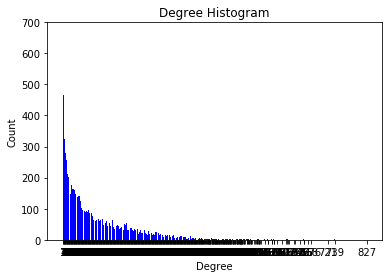

In [72]:
degree_sequence = sorted([d for n, d in movieSG.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()

In [73]:
Compute the Personalized PageRank on the small graph

SyntaxError: invalid syntax (<ipython-input-73-4436c2656a25>, line 1)

In [80]:
def pagerank(G, p = None): 
    t = time.time()
    pr = nx.pagerank_scipy(G, personalization= p, max_iter=200)
    print('scipy PR {} seconds'.format(time.time() - t))
    return pr
#print(pr)

In [77]:
movies_meta[movies_meta.title.str.match('.*Iron.*')]

,wID,fID,title,date,genres
555,30548208,/m/0g9wdmc,The Iron Lady,2011-12-26,"{""/m/017fp"": ""Biography"", ""/m/07s9rl0"": ""Drama""}"
1202,24708749,/m/04yg13l,Ironclad,2011-03-04,"{""/m/02kdv5l"": ""Action"", ""/m/02p0szs"": ""Histor..."
1591,2261407,/m/06_1x0,3-Iron,2004,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5n2f"": ""J..."
2352,22144721,/m/05qbckf,Iron Man 2,2010-04-26,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/01jfsb""..."
5092,1164646,/m/04cq1k,Iron Jawed Angels,2004-01-16,"{""/m/0219x_"": ""Indie"", ""/m/01f9r0"": ""Docudrama..."
5114,842825,/m/03g7m3,The Iron Giant,1999-07-31,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""..."
6986,11036762,/m/02qyv3h,Iron Sky,2012-02-11,"{""/m/05p553"": ""Comedy film"", ""/m/02kdv5l"": ""Ac..."
20960,30849012,/m/0gffxdg,Iron Invader,2011-02-12,"{""/m/06n90"": ""Science Fiction"", ""/m/07s9rl0"": ..."
22651,5838045,/m/0f88sr,Hellboy: Blood and Iron,2007-03-17,"{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""..."
22796,5109880,/m/0d329_,The Iron Ladies,2000-03-08,"{""/m/0hn10"": ""LGBT"", ""/m/0gsy3b"": ""Sex comedy""..."


In [81]:
pr = pagerank(movieSG, p={5676692 : 1})
sorted_nodes = [
    w  for (w, _) in sorted(pr.items(), key=lambda kv: kv[1], reverse=True)
]

scipy PR 4.978851079940796 seconds


In [82]:
print(sorted_nodes[:10])

[5676692, 22144721, 22114132, 22144990, 1022566, 723288, 2654186, 11942501, 2374400, 506119]


In [83]:
movies_meta[movies_meta.wID.isin(sorted_nodes[:10])].head()

,wID,fID,title,date,genres
1312,2374400,/m/077dlr,"Our Friend, Martin",1999,"{""/m/0hj3myq"": ""Children's/Family"", ""/m/02h8pk..."
2352,22144721,/m/05qbckf,Iron Man 2,2010-04-26,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/01jfsb""..."
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,"{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
37601,22144990,/m/0bc1yhb,Iron Man 3,2013-04-24,"{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
46672,5676692,/m/0dzlbx,Iron Man,2008-04-14,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
